### Exploring medical diagnosis by building a state-of-the-art chest X-ray classifier using Keras

In [4]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.densenet import DenseNet121
from keras.layers import Dense, GlobalAveragePooling2D
from keras.models import Model
from keras import backend as K
from keras.models import load_model
import tensorflow as tf
from tensorflow import keras
import util

Using TensorFlow backend.


The small dataset is annotated by consensus among four different radiologists for 5 pathologies: 
1. Consolidation
2. Edema
3. Effusion
4. Cardiomegaly
5. Atelectasis

In [5]:
#read data
train_df=pd.read_csv("train-small.csv")
valid_df=pd.read_csv("valid-small.csv")
test_df=pd.read_csv("test.csv")

In [6]:
#check the train dataset
train_df.head()

,Image,Atelectasis,Cardiomegaly,Consolidation,Edema,Effusion,Emphysema,Fibrosis,Hernia,Infiltration,Mass,Nodule,PatientId,Pleural_Thickening,Pneumonia,Pneumothorax
0,00008270_015.png,0,0,0,0,0,0,0,0,0,0,0,8270,0,0,0
1,00029855_001.png,1,0,0,0,1,0,0,0,1,0,0,29855,0,0,0
2,00001297_000.png,0,0,0,0,0,0,0,0,0,0,0,1297,1,0,0
3,00012359_002.png,0,0,0,0,0,0,0,0,0,0,0,12359,0,0,0
4,00017951_001.png,0,0,0,0,0,0,0,0,1,0,0,17951,0,0,0


In [7]:
labels = ['Cardiomegaly', 
          'Emphysema', 
          'Effusion', 
          'Hernia', 
          'Infiltration', 
          'Mass', 
          'Nodule', 
          'Atelectasis',
          'Pneumothorax',
          'Pleural_Thickening', 
          'Pneumonia', 
          'Fibrosis', 
          'Edema', 
          'Consolidation']

Data Leakage is one of the major issues in medical AI where same patients have multiple images in train, test or validation sets. This will cause our model to be biased to some patients. Hence, we must make sure that no patients in our test set are also present in either the train or validation sets.

In [8]:
def check_for_leakage(df1, df2, patient_col):
    #this function returns true if there are any patients in both df1 and df2 citing data leakage
    
    df1_patients_unique=set(df1[patient_col].values)
    df2_patients_unique=set(df2[patient_col].values)
    patients_in_both_groups=list(df1_patients_unique.intersection(df2_patients_unique))
    leakage=True if (len(patients_in_both_groups)>=1) else False
    return leakage
    

In [9]:
#check if there is leakage in train and test, and valid and test
train_test_leak=check_for_leakage(train_df, test_df, 'PatientId')
valid_test_leak=check_for_leakage(valid_df, test_df, 'PatientId')
print("leakage between train and test set: {}".format(train_test_leak))
print("leakage between valid and test set: {}".format(valid_test_leak))

leakage between train and test set: False
leakage between valid and test set: False


### Preparing Images
1. Normalizing mean and sd of the data. This standardizes the input distribution.
2. Shuffling the input after each epoch 
3. Setting the image size to 320 px by 320 px
4. Converting the 1-channel X-ray image to a 3-channel format by repeating the values in image across all channels. This is required because the pre-trained model that we will use DenseNet121 requires 3-channel input.

In [11]:
def get_train_generator(df, image_dir, x_col, y_cols, shuffle=True, batch_size=8, seed=1, target_w=320, target_h=320):
    #this function returns train_generator which is a dataframe iterator that iterates over training set
    
    print("working on train_generator.....")
    #normalize images
    image_generator=ImageDataGenerator(
        samplewise_center=True,
        samplewise_std_normalization=True)
    
    #flow from directory with specified batch and target size
    generator=image_generator.flow_from_dataframe(
        dataframe=df,
        directory=image_dir,
        x_col=x_col,
        y_col=y_cols,
        class_mode="raw",
        batch_size=batch_size,
        shuffle=shuffle,
        seed=seed,
        target_size=(target_w, target_h))
    
    return generator

We now build generator for valid and test sets. 

##### Why can't we use the same generator as for the training data?

Look back at the generator we wrote for the training data.

It normalizes each image per batch, meaning that it uses batch statistics.
We should not do this with the test and validation data, since in a real life scenario we don't process incoming images a batch at a time (we process one image at a time). Knowing the average per batch of test data would effectively give our model an advantage. The model should not have any information about the test data. 

We also normalize test data using the statistics computed from the training set. There is one technical note. Ideally, we would want to compute our sample mean and standard deviation using the entire training set. However, since this is extremely large, that would be very time consuming. In the interest of time, we'll take a random sample of the dataset and calcualte the sample mean and sample standard deviation.

In [12]:
def get_test_and_valid_generator(valid_df, test_df, train_df, image_dir, x_col, y_cols, sample_size=100, batch_size=8, seed=1, target_w = 320, target_h = 320):
    print("working on test and valid generator....")
    
    #get generator to sample dataset
    raw_train_generator=ImageDataGenerator().flow_from_dataframe(
        dataframe=train_df,
        directory=IMAGE_DIR,
        x_col="Image",
        y_col=labels,
        class_mode="raw",
        batch_size=sample_size,
        shuffle=True,
        target_size=(target_w, target_h))
    
    #get data sample
    batch=raw_train_generator.next()
    data_sample=batch[0]
    
    #use sample to fit mean and standard deviation for test set generator
    image_generator=ImageDataGenerator(
        featurewise_center=True,
        featurewise_std_normalization=True)
    
    #fit generator to sample from training data
    image_generator.fit(data_sample)
    
    #get valid and test generator
    valid_generator = image_generator.flow_from_dataframe(
            dataframe=valid_df,
            directory=image_dir,
            x_col=x_col,
            y_col=y_cols,
            class_mode="raw",
            batch_size=batch_size,
            shuffle=False,
            seed=seed,
            target_size=(target_w,target_h))

    test_generator = image_generator.flow_from_dataframe(
            dataframe=test_df,
            directory=image_dir,
            x_col=x_col,
            y_col=y_cols,
            class_mode="raw",
            batch_size=batch_size,
            shuffle=False,
            seed=seed,
            target_size=(target_w,target_h))
    return valid_generator, test_generator

In [13]:
IMAGE_DIR="C:/Users/User/Desktop/Dipkamal/nih/images-small/"
train_generator = get_train_generator(train_df, IMAGE_DIR, "Image", labels)
valid_generator, test_generator= get_test_and_valid_generator(valid_df, test_df, train_df, IMAGE_DIR, "Image", labels)

working on train_generator.....
Found 1000 validated image filenames.
working on test and valid generator....
Found 1000 validated image filenames.
Found 200 validated image filenames.
Found 420 validated image filenames.


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


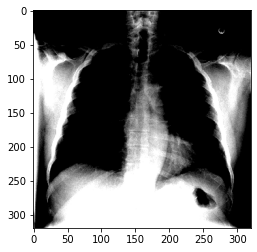

In [14]:
#Observe what the generator gives our model during training and validation 
x,y=train_generator.__getitem__(0)
plt.imshow(x[0])

## Model Development


Ideally, we would train our model using an evenly balanced dataset so that the positive and negative training cases would contribute equally to the loss. But in real practice, the positive and negative classes are unequal. Hence, if we use a normal cross-entropy loss function with a highly unbalanced dataset, then the algorithm will be incentivized to prioritize the majority class (either positive or negative), since it contributes more to the loss. Hence, we need to address this first. 

In [15]:
def compute_class_freqs(labels):
    #function to compute ratio of positive and negative data on each class
    N=labels.shape[0] #total number of patients 
    positive_frequencies=np.sum(labels==1, axis=0)/N
    negative_frequencies=np.sum(labels==0, axis=0)/N
    
    return positive_frequencies, negative_frequencies
    

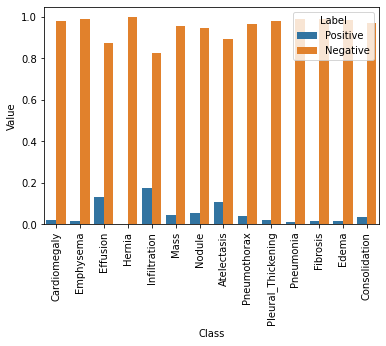

In [16]:
#compute positive negative frequencies for our data and visualize them
freq_pos, freq_neg=compute_class_freqs(train_generator.labels)
data = pd.DataFrame({"Class": labels, "Label": "Positive", "Value": freq_pos})
data = data.append([{"Class": labels[l], "Label": "Negative", "Value": v} for l,v in enumerate(freq_neg)], ignore_index=True)
plt.xticks(rotation=90)
f = sns.barplot(x="Class", y="Value", hue="Label" ,data=data)

As we see in the above plot, the contributions of positive cases is significantly lower than that of the negative ones. However, we want the contributions to be equal. One way of doing this is by multiplying each example from each class by a class-specific weight factor, $w_{pos}$ and $w_{neg}$, so that the overall contribution of each class is the same. 

To have this, we want 

$$w_{pos} \times freq_{p} = w_{neg} \times freq_{n},$$

which we can do simply by taking 

$$w_{pos} = freq_{neg}$$
$$w_{neg} = freq_{pos}$$

This way, we will be balancing the contribution of positive and negative labels.

In [17]:
pos_weights = freq_neg
neg_weights = freq_pos
pos_contribution = freq_pos * pos_weights 
neg_contribution = freq_neg * neg_weights

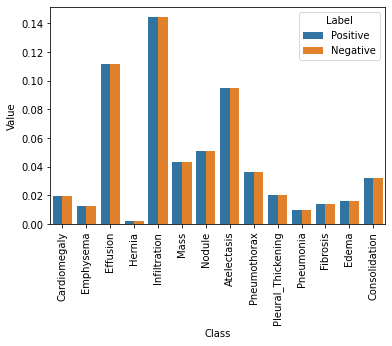

In [18]:
data = pd.DataFrame({"Class": labels, "Label": "Positive", "Value": pos_contribution})
data = data.append([{"Class": labels[l], "Label": "Negative", "Value": v} 
                        for l,v in enumerate(neg_contribution)], ignore_index=True)
plt.xticks(rotation=90)
sns.barplot(x="Class", y="Value", hue="Label" ,data=data);

In [19]:
#returns a loss function that calculates the weighted loss
def get_weighted_loss(pos_weights, neg_weights, epsilon=1e-7):
    def weighted_loss(y_true, y_pred):
        loss=0.0
        for i in range(len(pos_weights)):
            loss += (-1*K.mean(pos_weights[i]*y_true[:,i]*K.log(y_pred[:,i]+epsilon)))+(-1*K.mean(neg_weights[i]*(1-y_true[:,i])*K.log(1-y_pred[:,i]+epsilon)))
        return loss
    return weighted_loss
    


### Use the pretrained DenseNet121 model

In [20]:
#create the base pre-trained model
base_model=DenseNet121(weights="densenet.hdf5", include_top=False)
x=base_model.output

#add a global spatial average pooling layer
x=GlobalAveragePooling2D()(x)

#add a logistic layer
predictions=Dense(len(labels), activation="sigmoid") (x)

model = Model(inputs=base_model.input, outputs=predictions)
model.compile(optimizer='adam', loss=get_weighted_loss(pos_weights, neg_weights),metrics=['accuracy'])

#add metrics=['accuracy'] in model

In [21]:
history = model.fit_generator(train_generator, 
                              validation_data=valid_generator,
                              steps_per_epoch=100, 
                              validation_steps=25, 
                              epochs = 3)




Epoch 1/3
100/100 [==============================] - 2504s 25s/step - loss: 0.9359 - acc: 0.1013 - val_loss: 1.5075 - val_acc: 0.0300
Epoch 2/3
100/100 [==============================] - 2515s 25s/step - loss: 0.8844 - acc: 0.0712 - val_loss: 1.2764 - val_acc: 0.1100
Epoch 3/3
100/100 [==============================] - 2515s 25s/step - loss: 0.8955 - acc: 0.0788 - val_loss: 1.6508 - val_acc: 0.0050


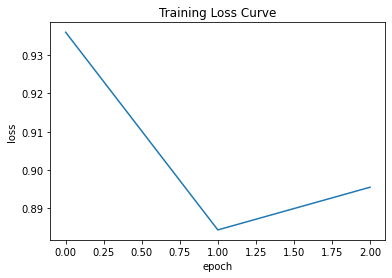

In [22]:
plt.plot(history.history['loss'])
plt.ylabel("loss")
plt.xlabel("epoch")
plt.title("Training Loss Curve")
plt.show()

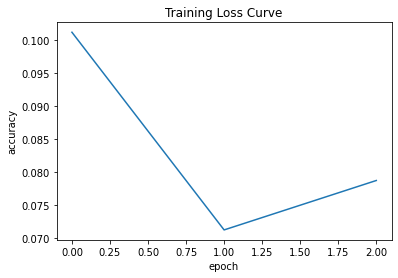

In [23]:
model.metrics_names
plt.plot(history.history['acc'])
plt.ylabel("accuracy")
plt.xlabel("epoch")
plt.title("Training Loss Curve")
plt.show()

In [24]:
predicted_vals = model.predict_generator(test_generator, steps = len(test_generator))

In [25]:
predicted_vals[2]

array([8.8342655e-01, 2.5334829e-01, 8.6972964e-01, 6.1333179e-05,
       9.3032873e-01, 9.9584377e-01, 4.8135513e-01, 8.8087773e-01,
       9.9019456e-01, 9.7080278e-01, 9.9962747e-01, 8.4618926e-03,
       9.9999940e-01, 8.9417124e-01], dtype=float32)

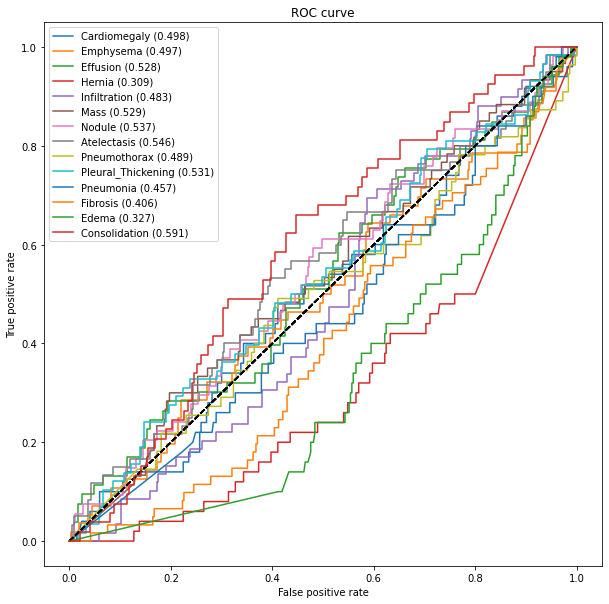

In [26]:
#roc curve and auc score
auc_rocs = util.get_roc_curve(labels, predicted_vals, test_generator)

### Visualizing learning with GradCAM

First we will load the small training set and setup to look at the 4 classes with the highest performing AUC measures.

In [27]:
df = pd.read_csv("train-small.csv")
IMAGE_DIR="C:/Users/User/Desktop/Dipkamal/nih/images-small/"

# only show the labels with top 4 AUC
labels_to_show = np.take(labels, np.argsort(auc_rocs)[::-1])[:4]

Loading original image
Generating gradcam for class Nodule
Generating gradcam for class Atelectasis
Generating gradcam for class Pleural_Thickening
Generating gradcam for class Consolidation


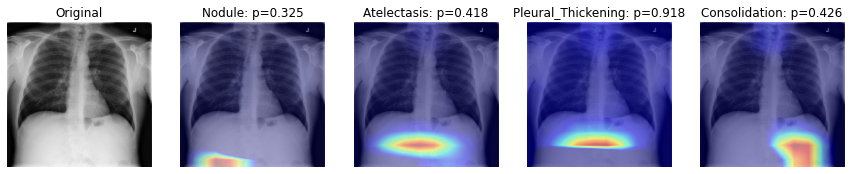

In [28]:
util.compute_gradcam(model, '00008270_015.png', IMAGE_DIR, df, labels, labels_to_show)

Loading original image
Generating gradcam for class Nodule
Generating gradcam for class Atelectasis
Generating gradcam for class Pleural_Thickening
Generating gradcam for class Consolidation


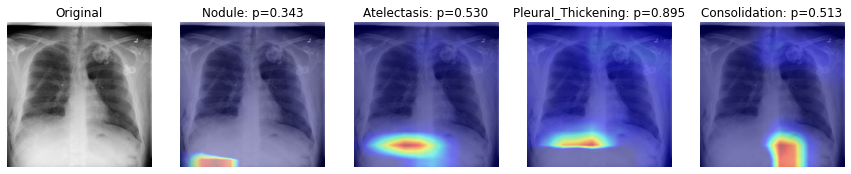

In [29]:
util.compute_gradcam(model, '00011355_002.png', IMAGE_DIR, df, labels, labels_to_show)

Loading original image
Generating gradcam for class Nodule
Generating gradcam for class Atelectasis
Generating gradcam for class Pleural_Thickening
Generating gradcam for class Consolidation


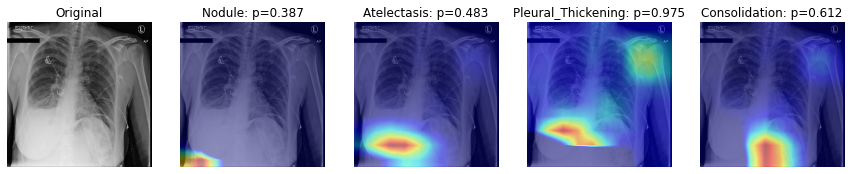

In [30]:
util.compute_gradcam(model, '00029855_001.png', IMAGE_DIR, df, labels, labels_to_show)

Loading original image
Generating gradcam for class Nodule
Generating gradcam for class Atelectasis
Generating gradcam for class Pleural_Thickening
Generating gradcam for class Consolidation


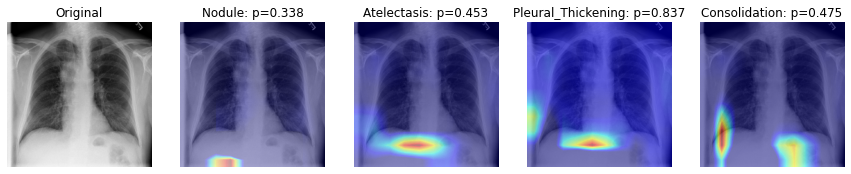

In [31]:
util.compute_gradcam(model, '00005410_000.png', IMAGE_DIR, df, labels, labels_to_show)

In [32]:
y_true, y_pred = [], []
for pred, arr in zip(predicted_vals, test_generator.labels):
    y_true.append(np.argmax(arr))
    y_pred.append(np.argmax(pred))
y_true = np.array(y_true)
y_pred = np.array(y_pred)
print("y_true:", y_true)
print("y_pred:", y_pred)

y_true: [ 2  3  3  3  3  3  3  3  2  3  3  3  3  3  3  3  3  3  3  3  2  3  2  2
  3  3  1  3  3  3  3  3  3  3  3  3  3  3  0  3  3  1  3  3  0  3  3  3
  3  3  7 10  2 10  2 10  4 10 10 10 10 10  2  2  4 10 10  4 10  4  4 10
 10  4 10  5 10  4  5 10 10 10  0  4 10 10 10 10  2  7 10 11 11 11 11 11
  7 11 11 11  5 11 11  4 11 11  5  0  7 11 11  9  8 11 11  7 11 11  1 11
 11 11 11 11  4  9  7 11 11  2 11  4 11 11 11 11 11 11  5  5  4  4 11  7
  2  4  4 12  2 12  0  2  7  2  0 12 12 12  2 12 12 12 12 12 12 12 12 12
  4  9 12  5 12  0 10  4 10 12  2  4 10 12 12  9  1  1  1  1  1  1  1  1
  1  1  1  1  1  0  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  0  1  1  1  1  1  1  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  5  9  9  7  9  9  9  9  4  9  9  5  1  9  9  9
  2  9  5  5  7  1  4  2  9  9  9  9  9  7  6  9  2  4  6  2  6  6  6  6
  6  4  6  6  6  6  6  4  4  6  2  2  6  6 

In [33]:
from sklearn.metrics import confusion_matrix

conf_mat = confusion_matrix(y_true, y_pred, labels=range(14))
conf_mat

array([[ 0,  0,  0,  0,  0,  7,  0,  1,  0, 11,  0,  0, 31,  0],
       [ 0,  0,  0,  0,  0,  7,  0,  3,  1, 10,  2,  0, 30,  1],
       [ 0,  0,  0,  0,  0,  3,  0,  1,  3,  4,  1,  0, 20,  0],
       [ 1,  0,  0,  0,  0,  9,  0,  0,  1,  2,  9,  0, 18,  1],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  6,  5,  0, 21,  0],
       [ 0,  0,  0,  0,  0,  2,  0,  0,  1,  8,  7,  0, 17,  0],
       [ 1,  0,  0,  0,  0,  4,  0,  0,  0,  6,  0,  0, 18,  1],
       [ 0,  0,  0,  0,  0,  4,  0,  0,  0,  5,  2,  0,  8,  0],
       [ 0,  0,  0,  0,  0,  3,  0,  0,  0,  1,  2,  0, 10,  0],
       [ 0,  0,  0,  0,  0,  3,  0,  1,  0,  2,  1,  0, 15,  0],
       [ 1,  0,  0,  0,  0,  2,  0,  0,  0,  7,  2,  0, 15,  0],
       [ 1,  0,  0,  0,  0,  5,  0,  0,  0,  3,  1,  0, 23,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  8,  0,  0, 11,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  3,  0,  0,  6,  1]],
      dtype=int64)

In [34]:
def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
   
   
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

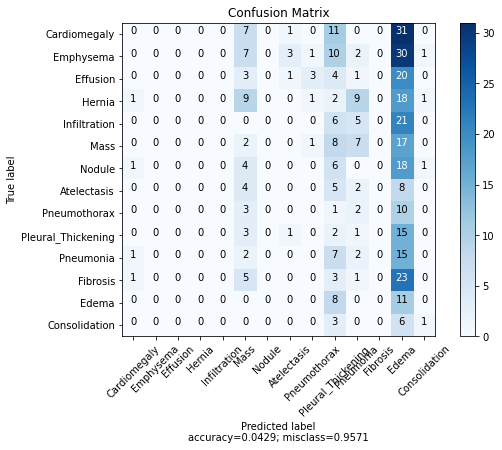

In [35]:
plot_confusion_matrix(cm           = conf_mat, 
                      normalize    = False,
                      target_names = labels,
                      title        = "Confusion Matrix")

In [36]:
from sklearn.metrics import plot_confusion_matrix, confusion_matrix, multilabel_confusion_matrix, plot_roc_curve, accuracy_score, roc_curve, classification_report
confusion_matrix(labels, predictions)

TypeError: Expected sequence or array-like, got <class 'tensorflow.python.framework.ops.Tensor'>

In [37]:
cr = classification_report(y_true, y_pred, target_names=labels)
print(cr)

                    precision    recall  f1-score   support

      Cardiomegaly       0.00      0.00      0.00        50
         Emphysema       0.00      0.00      0.00        54
          Effusion       0.00      0.00      0.00        32
            Hernia       0.00      0.00      0.00        41
      Infiltration       0.00      0.00      0.00        32
              Mass       0.04      0.06      0.05        35
            Nodule       0.00      0.00      0.00        30
       Atelectasis       0.00      0.00      0.00        19
      Pneumothorax       0.00      0.00      0.00        16
Pleural_Thickening       0.03      0.09      0.04        22
         Pneumonia       0.06      0.07      0.07        27
          Fibrosis       0.00      0.00      0.00        33
             Edema       0.05      0.58      0.08        19
     Consolidation       0.25      0.10      0.14        10

          accuracy                           0.04       420
         macro avg       0.03      0.0

C:\Users\User\anaconda3\envs\project1\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\User\anaconda3\envs\project1\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\User\anaconda3\envs\project1\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
